# Imports/utility functions

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import gc, os, cna, warnings
import scanpy as sc
import vima.data.samples as vds
import vima.data.patchcollection as vdp
import vima.vis as vv
from PIL import Image
fs_axislabel = 10
fs_figsubpanel = 14
fs_legend = 8

# Prepare

## read data

In [10]:
d = cna.read('_results/default-vae.h5ad'); d.sampleid = 'sid'

# read in cells
cells = pd.read_csv('../../ALZ/alz-data/SEAAD_MTG_MERFISH_metadata.2024-05-03.noblanks.harmonized.txt', sep='\t')
cells['sid'] = cells.Section.str.split('_').str[1]
coarsecelltypes = cells.class_name.unique()
celltypes = cells.subclass_name.unique()
subcelltypes = cells.supertype_name.unique()

# read in samples
repname = 'pca_k=10_harmony'
samples = vds.read_samples(f'../../ALZ/alz-data/10u/{repname}/*.nc', vds.default_parser)

100%|███████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.28it/s]


# Main case-control figure

In [27]:
from io import BytesIO
from PIL import Image
def spatial_locations(ax, ncols, sids):
    sortkey = pd.Series(range(len(sids)), index=sids)
    fig = vv.spatialplot(samples,
                   sortkey,
                   d.obs,
                   [
                       (d.obs['L2/3 IT'] / d.obs.totalcells).fillna(0),
                       (d.obs['L6b']*5 / d.obs.totalcells).fillna(0)
                   ],
                   rgbs=[
                       [0.,0.8,0.],
                       [0/255., 195/255., 255/255.]
                   ],
                   labels=d.samplem.case.map({True:'Dementia',False:'Control'}),
                   label_fontsize=fs_axislabel,
                   highlights=[
                       # d.obs.ncorr_thresh > 0,
                       d.obs.ncorr_thresh < 0
                   ],
                   outline_rgbas=[
                       # [1,0,0,1],
                       [0,0,1,1]
                   ], outline_thickness=15,
                   skipthresh=200, skipevery=1,
                   vmax=5, ncols=ncols, size=2, show=False)
    fig.tight_layout()
    buff = BytesIO()
    fig.savefig(buff, format="png", bbox_inches="tight", dpi=800)
    plt.close(fig)
    buff.seek(0)
    ax.imshow(Image.open(buff))
    ax.axis('off')

from matplotlib.patches import Rectangle
def spatial_legend(ax):
    lines = [
        plt.scatter([],[], marker='o', s=5, color=[0.,0.8,0.], label='L2/3'),
        plt.scatter([],[], marker='o', s=5, color=[0/255., 195/255., 255/255.], label='L6'),
        plt.scatter([],[], marker='o', facecolors='none', linewidths=2, s=5, color=[1, 0, 0], label='Dementia-associated'),
        plt.scatter([],[], marker='o', facecolors='none', linewidths=2, s=5, color=[0, 0, 1], label='Control-associated'),
    ]
    legend = ax.legend(handles=lines, loc="center", markerscale=2, ncols=4, frameon=False,
                       columnspacing=0.3, handletextpad=0.01,
                       fontsize=fs_legend, labelcolor='white')
    bbox = legend.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
    rect = Rectangle(
        (bbox.x0, bbox.y0),
        bbox.width,
        bbox.height,
        transform=ax.transAxes,
        color="black",
        zorder=legend.get_zorder() - 1
    )
    ax.add_patch(rect)
    ax.axis('off')

def umap(ax, title=''):    
    sc.pl.umap(d, ax=ax, show=False, s=2)
    sc.pl.umap(d[d.obs.ncorr_thresh != 0], color='ncorr_thresh', cmap='seismic', vmin=-1, vmax=1, s=7, ax=ax, show=False,
               colorbar_loc=None, frameon=False, title=title)

    p = 0.0023499765002349977
    formatted = f"${p:.1e}"
    formatted_latex = formatted.replace('-0', '-').replace("e", r" \times 10^{").replace("+", "").replace("-", r"-") + "}$"
    ax.text(1.5, -2, f'P={formatted_latex}', ha='left', va='bottom', fontsize=fs_legend, fontweight='medium')

def classification(ax):
    df = d.samplem[d.samplem.npatches >= 1]
    cases = df[df.case]
    ctrls = df[~df.case]
    for x, l, c in [(cases, 'Dementia', 'red'), (ctrls, 'Control', 'blue')]:
        ax.scatter(100*x.nneg/(x.npatches), 100*x.npos/(x.npatches), color=c, label=l, alpha=0.5)
    ax.set_xlabel('%Control patches', fontsize=fs_axislabel, labelpad=-5)
    ax.set_ylabel('%Dementia patches', fontsize=fs_axislabel, labelpad=-0.5)
    ax.set_yticks([0,4]); ax.set_xticks([0,25])
    ax.legend(labelspacing=0.4,  # Reduce vertical spacing between labels
        handlelength=1.0,  # Shorten the marker length
        handletextpad=0.5,  # Reduce space between marker and label
        borderpad=0.4,  # Reduce padding around the edges
        fontsize=fs_legend)  # Adjust font size (optional))
    ax.spines[['right','top']].set_visible(False)

from scipy.stats import ks_2samp
import seaborn as sns
def twosample(ax, name, xlabel, alternative, ymax, ytick):
    case = d.samplem[d.samplem.case][name]
    ctrl = d.samplem[~d.samplem.case][name]
    
    sns.swarmplot(y=name, x='case', data=d.samplem, ax=ax, s=4)
    sns.boxplot(x='case', y=name, data=d.samplem, whis=1.5, width=0.5, boxprops={'alpha': 0.3}, showfliers=False, ax=ax)
    
    ax.set_ylim(ax.get_ylim()[0], ymax)
    ax.set_xticks([0,1],['Control','Dementia'], va='center', rotation=15)
    ax.tick_params(axis='x', pad=10)
    ax.set_xlabel('')
    ax.set_ylabel(xlabel, fontsize=fs_axislabel, labelpad=-2)
    ax.set_yticks([0,ytick],['0',f'{ytick}'])
    ax.spines[['right','top']].set_visible(False)
    
    p = ks_2samp(case, ctrl, alternative=alternative).pvalue
    formatted = f"${p:.1e}"
    formatted_latex = formatted.replace('-0', '-').replace("e", r" \times 10^{").replace("+", "").replace("-", r"-") + "}$"
    ax.text(0.5, ymax, f'P={formatted_latex}', ha='center', va='top', fontsize=fs_legend, fontweight='medium')

def violinplot(ax, cts):
    if cts is None:
        cts = celltypes
    pos = (d.obs.L6b / d.obs.totalcells >= 0.05) & (d.obs.ncorr_thresh > 0)
    neg = (d.obs.L6b / d.obs.totalcells >= 0.05) & (d.obs.ncorr_thresh <= 0)
    vv.diff_markers(d.obs[celltypes].div(d.obs.totalcells, axis=0).fillna(0),
                    d.obs[pos].index, d.obs[neg].index, cts,
                    labels=['Dementia-associated L6','Other L6'], nmarkers=4, ascending=False, ax=ax, show=False,
                    split=True, inner='quart', density_norm='count',
                    palette={'Dementia-associated L6': "red", 'Other L6': "#00C3FF"})
    ax.text(0, 0.9, '*', ha='center', fontsize=fs_axislabel+2)
    ax.text(3, 0.45, '*', ha='center', fontsize=fs_axislabel+2)
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, title=None)
    ax.set_ylabel('Prop. cells in patch', fontsize=fs_axislabel)
    ax.set_yticks([0,0.5])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
    ax.set_xlabel('')
    ax.spines[['right','top']].set_visible(False)

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_97937/200668701.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sids = d.samplem[d.obs.sid.value_counts() > 200].sort_values(by='sortkey').iloc[


............

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_97937/3773314575.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


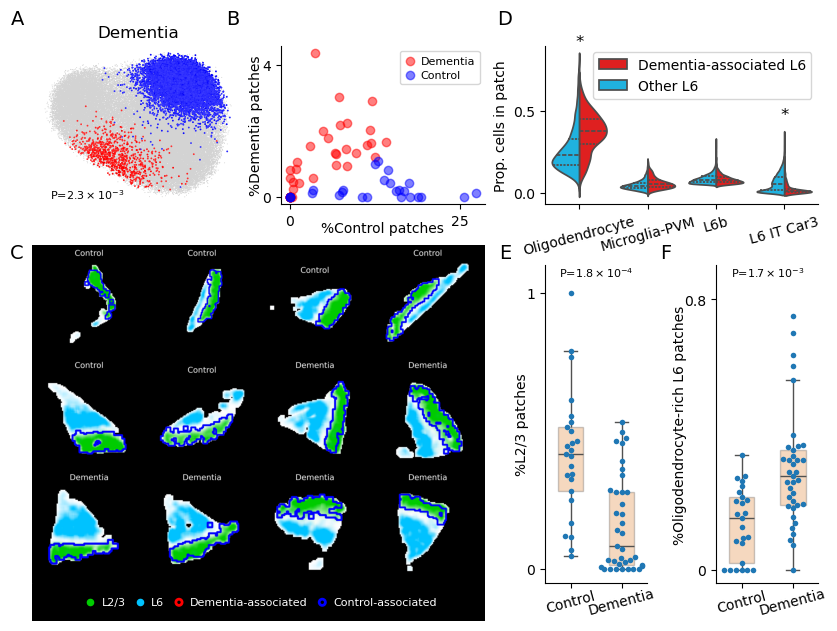

In [28]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8,6), constrained_layout=True)
width_ratios = np.array([1.5, 1.5, 0.75, 0.75])
height_ratios = np.array([1, 2])
spatial_width = width_ratios[:2].sum() / width_ratios.sum() - 0.1
spatial_height = height_ratios[1:].sum() / height_ratios.sum() - 0.04
gs = GridSpec(2, 4, width_ratios=width_ratios, height_ratios=height_ratios, figure=fig)

d.samplem['sortkey'] = d.samplem.npos / (d.samplem.nneg + 1)
sids = d.samplem[d.obs.sid.value_counts() > 200].sort_values(by='sortkey').iloc[
    [0,10,11,14,16,18] + #control
    [26,27,28,31,32,36]].index

umap(fig.add_subplot(gs[0,0]), title='Dementia')
classification(fig.add_subplot(gs[0,1]))
spatial_locations(fig.add_axes([0, spatial_height / 10, spatial_width, 9*spatial_height/10]), 4, sids)
spatial_legend(fig.add_axes([0, 0, spatial_width-0.0005, spatial_height/10]))

violinplot(fig.add_subplot(gs[0,2:]), ['Oligodendrocyte','Microglia-PVM','L6b','L6 IT Car3'])
twosample(fig.add_subplot(gs[1,2]), 'frac_layer23', '%L2/3 patches', 'greater', 1.1, 1)
twosample(fig.add_subplot(gs[1,3]), 'frac_layer6_manyoligo', '%Oligodendrocyte-rich L6 patches', 'less', 0.9, 0.8)

# subpart labels
fig.text(-0.01, 1.02, 'A', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.26, 1.02, 'B', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(-0.01, 0.63, 'C', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.6, 1.02, 'D', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.6, 0.63, 'E', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.8, 0.63, 'F', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')

fig.savefig('../_main/fig.ALZ.pdf', bbox_inches='tight', dpi=800)
fig.savefig('../_main/fig.ALZ.png', bbox_inches='tight', dpi=500)
plt.show()

# Supp

In [2]:
def volcano(ax, resultsfile):
    ttest = pd.read_csv(resultsfile)
    ax.scatter(ttest.stat, -np.log10(ttest.p), alpha=0.7)
    ax.axhline(y=-np.log10(0.05/len(ttest)), ls='--', color='gray')
    ax.axvline(x=0, ls='-', color='black')
    ax.set_xlabel('Corr. to case status', fontsize=fs_axislabel)
    ax.set_ylabel('$-\\log_{10}(P)$', fontsize=fs_axislabel)
    ax.spines[['right', 'top']].set_visible(False)

## marker list

In [11]:
sample = vds.read_samples(f'../../ALZ/alz-data/10u/counts/H20.33.002_1217501029.nc', vds.default_parser)
markers = list(sample.values())[0].marker.values
markers = [m for m in markers if 'Blank' not in m]
table = np.array([markers[i:i+20] for i in range(0, len(markers), 20)])
df = pd.DataFrame(table).T

df[''] = ''
df.style.hide(axis=0).hide(axis=1) \
    .to_latex('../_supp/table.ALZ.markers.tex', convert_css=True)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


# UMAP showing clusters of patch fingerprints

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_97937/2232309598.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(d)


<Figure size 500x400 with 0 Axes>

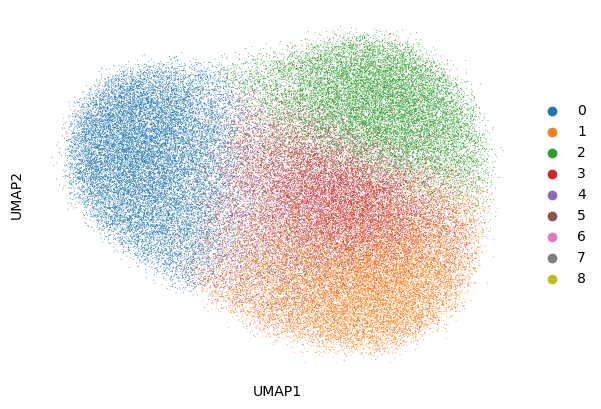

In [30]:
plt.figure(figsize=(5,4))
sc.tl.leiden(d)
sc.pl.umap(d, color='leiden', show=False)
plt.gca().spines[:].set_visible(False)
plt.title('')
plt.savefig('../_supp/fig.ALZ.umap_with_clusters.png', dpi=500)
plt.show()

## case-ctrl analysis of patch clusters with cell type representation

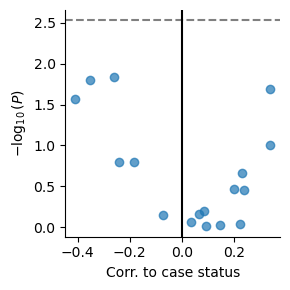

In [3]:
plt.figure(figsize=(3,3))
volcano(plt.gca(), '_results/patchcelltypecomposition_clustertest.csv')
plt.tight_layout()
plt.savefig('../_supp/fig.ALZ.volcano_patchcomposition.png', dpi=500)
plt.show()

## case-ctrl analysis of patch clusters with avg expression representation

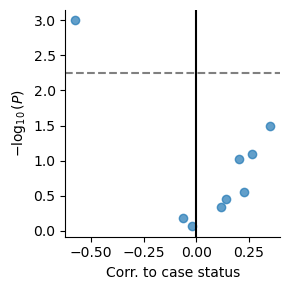

In [6]:
plt.figure(figsize=(3,3))
volcano(plt.gca(), '_results/patchfingerprints_clustertest.csv')
plt.tight_layout()
plt.savefig('../_supp/fig.ALZ.volcano_patchfingerprints.png', dpi=500)
plt.show()

## case-ctrl analysis with patch clusters with fingerprint representation

In [ ]:
plt.figure(figsize=(3,3))
volcano(plt.gca(), '_results/patchavg_clustertest.csv')
plt.tight_layout()
plt.savefig('../_supp/fig.ALZ.volcano_patchavg.png', dpi=500)
plt.show()

## case-ctrl analysis with sample-wide avg expression representation

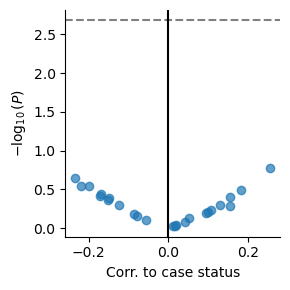

In [8]:
plt.figure(figsize=(3,3))
volcano(plt.gca(), '_results/samplecompositiontest.csv')
plt.tight_layout()
plt.savefig('../_supp/fig.ALZ.volcano_samplecomposition.png', dpi=500)
plt.show()

## Enrichments of cell types among dementia-associated layer 6 patches relative to other layer 6 patches

In [29]:
df = pd.read_csv('_results/dementia_enrichments_in_layer6.csv')
df.rename(columns={
    'L6_associated':'Abund(dementia)',
    'L6_nonassociated':'Abund(other)',
    'enrichment':'Enrich.',
    'P':'$P$',
    'P_{bonf}':'$P_{bonf}$'
    }, inplace=True)
df = df.sort_values(by=['P', 'Enrich.'])

formatters = {
    'Abundance (dementia L6)': lambda x: f"{x:.3g}",
    'Abundance (other L6)': lambda x: f"{x:.3g}",
    'Enrich.': lambda x: f"{x:.3g}",
    'P': lambda x: f"{x:.3g}",
    'P_{bonf}': lambda x: f"{x:.3g}",
}

df[''] = ''
df.style.hide() \
    .map_index(lambda v: "font-weight: bold;", axis="columns") \
    .format(formatters) \
    .to_latex('../_supp/table.ALZ.enrichments.tex', convert_css=True, hrules=True)